<a href="https://colab.research.google.com/github/Osterne/codes_DS_course/blob/main/05_mod_01_ap_sup_regressao_05_mlg_contagem_binomial_negativa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

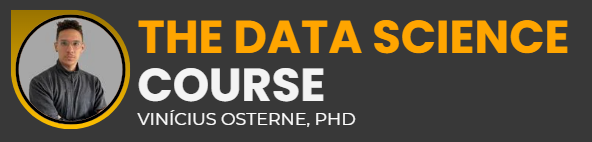

---

# Aprendizado Supervisionado - Modelos Baseados em Regressão

### Modelos Lineares Generalizados - Modelos para Dados de Contagem - Regressão Binomial Negativa

---
<br><br><br><br><br>

---

## 🚦 Motivação e Contexto

- 🔢 Exemplos de dados de contagem:  
  - 🚗 Número de acidentes de trânsito  
  - ☎️ Chamadas em call center  
  - 👨‍👩‍👧 Número de filhos por família  
  - 🏭 Falhas em máquinas industriais  

- ⚠️ Por que não usar Poisson?  
  - ❌ Poisson impõe **média = variância**.  
  - 📈 Em muitos dados reais há **superdispersão**:  
    $$
    \mathrm{Var}(Y) \gg \mathbb{E}[Y]
    $$
  - Isso **subestima erros-padrão** e **infla significância**.  

> 💡 **Motivação**: A **Binomial Negativa** adiciona um **parâmetro de dispersão** que permite variância maior que a média.  

<br><br><br>

---

## 🧩 Estrutura Geral dos Modelos Lineares Generalizados (MLG) para Binomial Negativa (NB2)

Um MLG é definido a partir de **três componentes principais**:

### 🎲 1. Componente Aleatório
- A variável resposta segue a **Binomial Negativa (NB2)**:  
  $$
  Y_i \sim \text{NB}(\mu_i, \alpha)
  $$
- Momentos:  
  $$
  \mathbb{E}[Y_i] = \mu_i, \qquad \text{Var}(Y_i) = \mu_i + \alpha \mu_i^2
  $$
  onde $\alpha > 0$ mede a **superdispersão**.  
- Limite: **Poisson** quando $\alpha \to 0$.  

---

### 📊 2. Componente Sistemático
- Representa a **combinação linear dos preditores**:  
  $$
  \eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}
  $$

---

### 🔗 3. Função de Ligação
- Conecta a média $\mu_i$ ao previsor linear $\eta_i$:  
  $$
  g(\mu_i) = \eta_i
  $$
- Ligação usual: **logarítmica**  
  $$
  \log(\mu_i) = \mathbf{x}_i^\top \boldsymbol{\beta}
  $$

| Ligação        | Fórmula            | Observações |
|----------------|--------------------|-------------|
| 🔑 **Log (canônica)** | $g(\mu) = \log(\mu)$ | Mais usada; garante $\mu > 0$; interpretação em termos de razão de taxas (IRR). |
| ➡️ **Identidade** | $g(\mu) = \mu$ | Interpretação direta; risco de $\mu \leq 0$. |

---

✅ **Resumo para a Regressão Binomial Negativa (NB2)**  
- **Aleatório**: $Y_i \sim \text{NB}(\mu_i, \alpha)$  
- **Sistemático**: $\eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}$  
- **Ligação**: $\log(\mu_i) = \eta_i$  

<br><br><br>

---

## ⚠️ Limitações da Binomial Negativa

- **Excesso de zeros** pode persistir → considerar **ZIP/ZINB**.  
- **Subdispersão** (variância < média) não é tratada.  
- Estimativa de $\alpha$ pode ser instável em amostras pequenas.  
- Se há heterogeneidade estruturada (clusters, painel), **modelos mistos** podem ser mais apropriados.  

<br><br><br>

---

## 🔍 Comparações e Critérios de Escolha

- **Diagnóstico de dispersão**:  
  - 📊 **Qui-quadrado de Pearson / GL**: ≈ 1 indica ajuste adequado; ≫ 1 indica superdispersão.  
  - 📊 **Deviance / GL**: mesmo raciocínio.  

- **Teste de aninhamento Poisson vs NB**:  
  - $H_0$: $\alpha=0$ (Poisson)  
  - $H_1$: $\alpha>0$ (NB)  
  - Teste de razão de verossimilhança favorece NB quando $\alpha > 0$.  

- **Critérios de informação (AIC, BIC)**:  
  - Quanto **menor**, melhor o ajuste penalizado.  

- **Regras práticas**:  
  - ✔️ **Poisson**: quando $\text{Var}(Y) \approx \mathbb{E}[Y]$.  
  - ✔️ **Binomial Negativa**: quando há superdispersão clara.  
  - ✔️ **Quasi-Poisson**: ajusta erros-padrão sem alterar a média.  
  - ✔️ **Zero-inflated (ZIP/ZINB)**: quando há excesso de zeros.  

<br><br><br>

---

## 🔍 Aplicação

- Pacotes necessários  
- Carregamento dos dados  
- Estatística Descritiva  
- Ajuste do Modelo  
- Interpretação dos resultados  
- Diagnóstico do ajuste


### Aplicação

In [1]:
# ----------------------------------------------------
# 1. Pacotes necessários
# ----------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
# ----------------------------------------------------
# 2. Carregamento dos dados
# ----------------------------------------------------
# Dataset 'quine' (MASS) — contagem de dias de ausência escolar
dados = sm.datasets.get_rdataset("quine", package="MASS").data.copy()

# Renomear colunas para português
dados = dados.rename(columns={
    "Days": "Dias",     # contagem de dias ausentes
    "Eth":  "Etnia",    # etnia
    "Sex":  "Sexo",     # sexo
    "Age":  "Idade",    # faixa etária
    "Lrn":  "Aprend"    # status de aprendizado
})

# Garantir que sejam categóricas
for col in ["Etnia","Sexo","Idade","Aprend"]:
    dados[col] = dados[col].astype("category")

dados.head(4)

,Etnia,Sexo,Idade,Aprend,Dias
0,A,M,F0,SL,2
1,A,M,F0,SL,11
2,A,M,F0,SL,14
3,A,M,F0,AL,5


In [3]:
# Variáveis do dataset quine (ausências escolares)

# Etnia (origem étnica do aluno)
# Etnia[Aboriginal]   -> alunos de origem aborígene
# Etnia[NonAboriginal] -> alunos não aborígenes (categoria de referência)

# Sexo (sexo do aluno)
# Sexo[F]  -> alunas do sexo feminino
# Sexo[M]  -> alunos do sexo masculino (categoria de referência)

# Idade (faixa etária do aluno)
# Idade[F0] -> alunos com 1ª faixa etária (aprox. 13 anos)
# Idade[F1] -> alunos com 2ª faixa etária (aprox. 14 anos)
# Idade[F2] -> alunos com 3ª faixa etária (aprox. 15 anos)
# Idade[F3] -> alunos com 4ª faixa etária (aprox. 16 anos) – categoria de referência

# Aprend (nível de aprendizado)
# Aprend[Slow] -> alunos classificados como de aprendizado lento
# Aprend[Average] -> alunos classificados como de aprendizado médio (categoria de referência)

# Variável resposta
# Dias -> número de dias de ausência escolar registrados

count    146.000000
mean      16.458904
std       16.253223
min        0.000000
25%        5.000000
50%       11.000000
75%       22.750000
max       81.000000
Name: Dias, dtype: float64
Média(Dias)=16.459 | Variância(Dias)=264.167


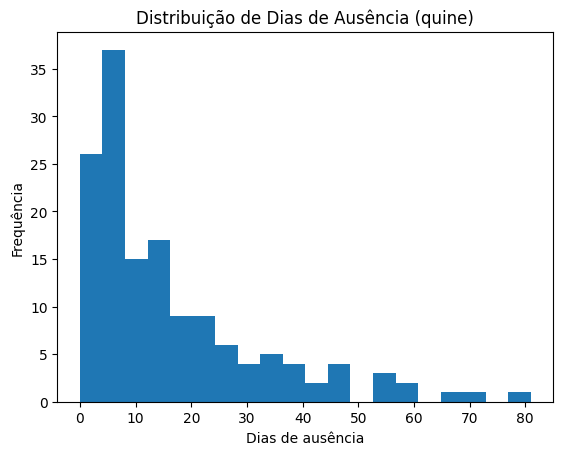

In [10]:
# ----------------------------------------------------
# 3. Estatística Descritiva
# ----------------------------------------------------
print(dados["Dias"].describe())

media_y = dados["Dias"].mean()
variancia_y = dados["Dias"].var()
print(f"Média(Dias)={media_y:.3f} | Variância(Dias)={variancia_y:.3f}")

# Distribuição
plt.figure()
plt.hist(dados["Dias"], bins=20)
plt.title("Distribuição de Dias de Ausência (quine)")
plt.xlabel("Dias de ausência")
plt.ylabel("Frequência")
plt.show()

In [5]:
# ----------------------------------------------------
# 4. Ajuste do Modelo
# ----------------------------------------------------
formula = "Dias ~ Etnia + Sexo + Idade + Aprend"

# Poisson
modelo_pois = smf.glm(
    formula=formula,
    data=dados,
    family=sm.families.Poisson()
).fit()

# Binomial Negativa (discreto, estima alpha)
modelo_nb = smf.negativebinomial(
    formula=formula,
    data=dados
).fit()

Optimization terminated successfully.
         Current function value: 3.743668
         Iterations: 22
         Function evaluations: 23
         Gradient evaluations: 23


In [11]:
# ----------------------------------------------------
# 5. Interpretação dos resultados
# ----------------------------------------------------
print("\n=== AIC ===")
print(f"AIC Poisson: {modelo_pois.aic:.3f}")
print(f"AIC NegBin : {modelo_nb.aic:.3f}")

# Razões de Taxa (IRR)
params_nb = modelo_nb.params.drop(labels=["alpha"], errors="ignore")
irr_nb = np.exp(params_nb)

params_pois = modelo_pois.params
irr_pois = np.exp(params_pois)

print("\nIRR Poisson:\n", irr_pois)
print("\nIRR NegBin:\n", irr_nb)


=== AIC ===
AIC Poisson: 2299.184
AIC NegBin : 1109.151

IRR Poisson:
 Intercept       15.110354
Etnia[T.N]       0.586487
Sexo[T.M]        1.175386
Idade[T.F1]      0.716124
Idade[T.F2]      1.294117
Idade[T.F3]      1.533716
Aprend[T.SL]     1.417568
dtype: float64

IRR NegBin:
 Intercept       18.075845
Etnia[T.N]       0.565884
Sexo[T.M]        1.085813
Idade[T.F1]      0.638628
Idade[T.F2]      1.092080
Idade[T.F3]      1.428905
Aprend[T.SL]     1.339235
dtype: float64


In [7]:
# ----------------------------------------------------
# Interpretação dos resultados (modelo Binomial Negativa)
# ----------------------------------------------------

# Intercepto (IRR = 18.08): taxa esperada de dias de ausência para o grupo de referência (Etnia = Aboriginal, Sexo = Feminino, Idade = F0, Aprend = Average).

# Etnia[T.N] (não aborígene, IRR = 0.57): alunos não aborígenes têm cerca de 43% menos dias de ausência em comparação com alunos aborígenes.

# Sexo[T.M] (masculino, IRR = 1.09): alunos do sexo masculino apresentam cerca de 8% mais dias de ausência que alunas, efeito pequeno.

# Idade[T.F1] (≈14 anos, IRR = 0.64): cerca de 36% menos ausências em comparação aos mais jovens (≈13 anos).
# Idade[T.F2] (≈15 anos, IRR = 1.09): aproximadamente 9% mais ausências em relação aos de 13 anos (referência).
# Idade[T.F3] (≈16 anos, IRR = 1.43): cerca de 43% mais dias de ausência em comparação aos de 13 anos.

# Aprend[T.SL] (aprendizado lento, IRR = 1.34): alunos classificados como de aprendizado lento apresentam cerca de 34% mais dias de ausência que alunos de aprendizado médio.


In [18]:
# ----------------------------------------------------
# 6. Diagnóstico do ajuste
# ----------------------------------------------------
# Dispersão do Poisson
pearson_pois = modelo_pois.pearson_chi2 / modelo_pois.df_resid
dev_pois = modelo_pois.deviance / modelo_pois.df_resid

# Alpha estimado pelo NB
alpha_est = float(modelo_nb.params["alpha"]) if "alpha" in modelo_nb.params.index else getattr(getattr(modelo_nb, "model", None), "alpha", 1.0)

# Refit GLM-NB com alpha fixo para diagnosticar dispersão
modelo_nb_glm = smf.glm(
    formula=formula,
    data=dados,
    family=sm.families.NegativeBinomial(alpha=alpha_est)
).fit()

pearson_nb = modelo_nb_glm.pearson_chi2 / modelo_nb_glm.df_resid
dev_nb = modelo_nb_glm.deviance / modelo_nb_glm.df_resid

print("\n=== Diagnóstico de Dispersão ===")
print(f"Alpha (NB) estimado ≈ {alpha_est:.4f}")
print(f"Pearson/df Poisson: {pearson_pois:.3f}")
print(f"Pearson/df NB-GLM: {pearson_nb:.3f}")
print(f"Deviance/df Poisson: {dev_pois:.3f}")
print(f"Deviance/df NB-GLM: {dev_nb:.3f}")


=== Diagnóstico de Dispersão ===
Alpha (NB) estimado ≈ 0.7844
Pearson/df Poisson: 13.167
Pearson/df NB-GLM: 0.991
Deviance/df Poisson: 12.207
Deviance/df NB-GLM: 1.208


In [9]:
# ----------------------------------------------------
# Interpretação do Diagnóstico de Dispersão
# ----------------------------------------------------

# Alpha (NB) estimado ≈ 0.7844: indica presença clara de superdispersão (α > 0).
# Pearson/df Poisson = 13.167: muito maior que 1, mostrando que o modelo Poisson não ajusta bem a variância (subestima os erros-padrão).
# Pearson/df NB-GLM = 0.991: próximo de 1, mostrando que a Binomial Negativa corrige adequadamente a dispersão.
# Deviance/df Poisson = 12.207: também muito acima de 1, confirmando má qualidade do ajuste pelo Poisson.
# Deviance/df NB-GLM = 1.208: valor próximo de 1, indicando que a Binomial Negativa captura bem a variabilidade dos dados.
